In [9]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import scanpy as sc

In [23]:
def sg_dataset(feas_fn, data_fn):
    print('load features')
    with open(feas_fn, 'rb') as f:
        features = pickle.load(f)#pd.read_pickle(f)
    features.set_index('image', inplace=True)
    
    print('load dataset')
    adata = sc.read_h5ad(data_fn)
    sc.pp.normalize_total(adata, target_sum=1e6)

    print('filter adata of single cells')
    adata_s = adata[adata.obs_names.isin(features.index)]

    print('filter genes')
    sc.pp.filter_genes(adata_s, min_cells=10)

    print('Add features to adata')
    for col in ['area', 'length', 'width', 'eccentricity', 'spectrum', 'wavelengths']:
        adata_s.obs[col] = features.loc[adata_s.obs_names][col]
        
    return adata_s

def get_correlation(adata_s, feas):
    #corr = dsim.correlation.correlate_features_phenotypes(feas, fillna=0)##
    exp = adata_s.X.T
    phe = adata_s.obs[feas].fillna(0)

    x = exp #(39466, 10)
    y = phe.values.T #(2, 10)

    from scipy.stats import rankdata

    xw = np.zeros(x.shape, float)
    for ii, xi in enumerate(x):
        xw[ii] = rankdata(xi, method='average')

    yw = np.zeros(y.shape, float)
    for ii, yi in enumerate(y):
        yw[ii] = rankdata(yi, method='average')

    xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
    yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
    n = xw.shape[1]
    r = np.dot(xw, yw.T) / n

    corr = pd.DataFrame(
                    data=r,
                    index=adata_s.var_names,
                    columns=phe.columns,
                    dtype=float)

    return corr

def plot_correlation(genes, adata_s, fea, xlabel, path, filetype=False):
    '''
    genes = {
    'positive': [],
    'negative': []
    }
    '''
    import itertools
    n_genes = len(list(itertools.chain.from_iterable(genes.values())))
    colors = sns.color_palette('tab10', n_genes)
    colors = [colors[: len(genes['positive'])], colors[len(genes['positive']):]]

    fig, axs = plt.subplots(2, 1, figsize=(4, 6), dpi=300)
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    
    for j, (ax, genes) in enumerate(zip(axs, [genes['positive'], genes['negative']])):
        for ig, gene in enumerate(genes):
            x = adata_s.obs[fea]
            y = adata_s[:, gene].X + 0.1
            idx = np.argsort(x)
            ax.scatter(
                x[idx], y[idx], alpha=0.8, label=gene, lw=2, color=colors[j][ig], s=10, 
            )
        ax.legend(fontsize=8, bbox_to_anchor=(1, 1))
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Gene exp [cpm]')
        ax.set_yscale('log')
        ax.set_xscale('log')

    axs[0].set_title('Positive correlation')
    axs[1].set_title('Negative correlation')
    fig.tight_layout()

    if filetype is not False:
        plt.savefig(save_figures + fea + filetype)
    
    return {'fig': fig, 'axs': axs}

In [20]:
abundance = pd.read_csv('/home/yike/phd/cancer_cells_img_seq/data/unmixing/abundance_2mols.tsv', sep='\t', index_col=0)

### add abundance information to dataset obs
data_fn = '/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/gene_filter.h5ad'
adata = sc.read_h5ad(data_fn)
adata.var_names_make_unique()
sc.pp.normalize_total(adata, target_sum=1e6)
for col in abundance.columns:
    adata.obs[col] = abundance.loc[adata.obs_names][col]

### folder to save files
save_figures = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/correlate_features/NAD(P)H/'

In [21]:
# load single cells
fdn_cell = '/home/yike/phd/cancer_cells_img_seq/figures/segmentation/cancer100cells/'
sig_cells = [i.split('.')[0] for i in os.listdir(fdn_cell) if '.npz' in i]

adata_s = adata[adata.obs_names.isin(sig_cells)]

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [22]:
feas = ['Free NAD(P)H', 'Protein bound NAD(P)H']
corr = get_correlation(adata_s, feas)
corr.to_csv(save_figures + 'correlation_abundance_log.tsv', sep='\t')

<ipython-input-18-b9c6060f402d>:41: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


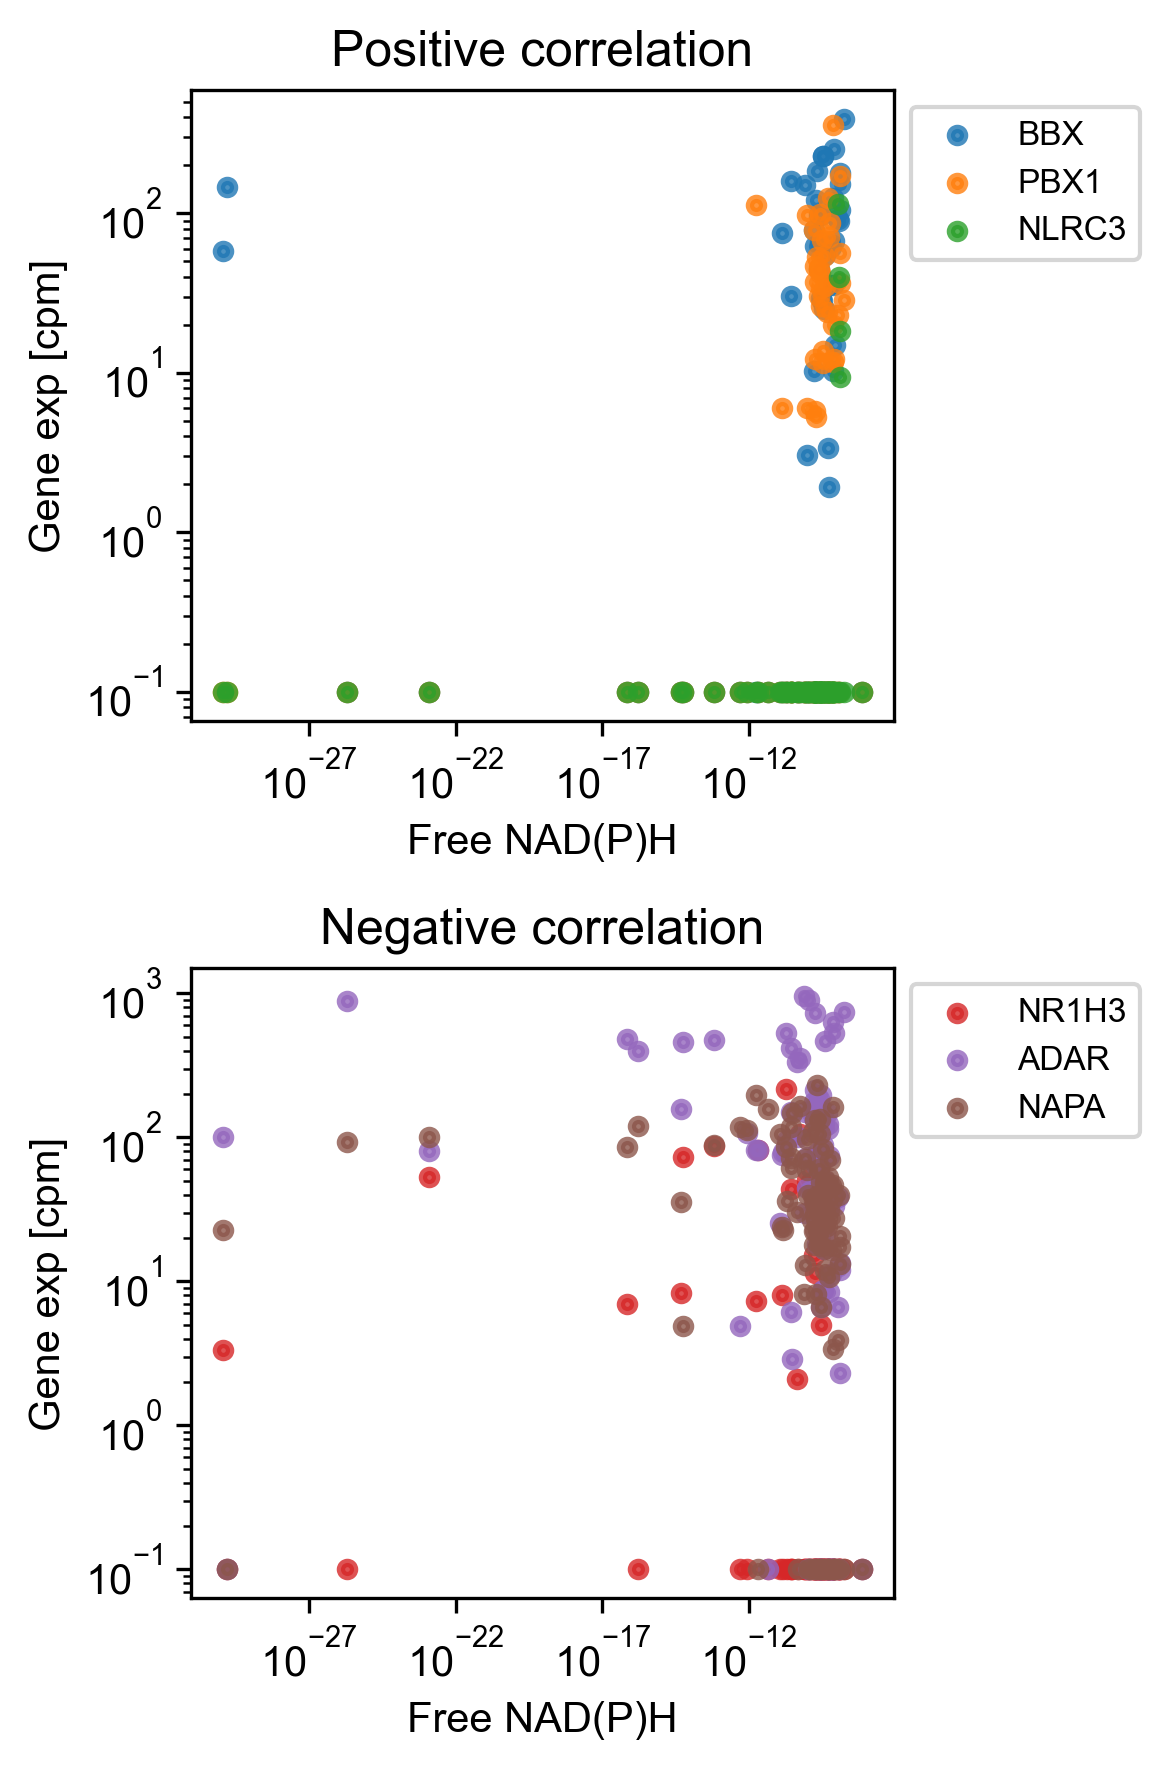

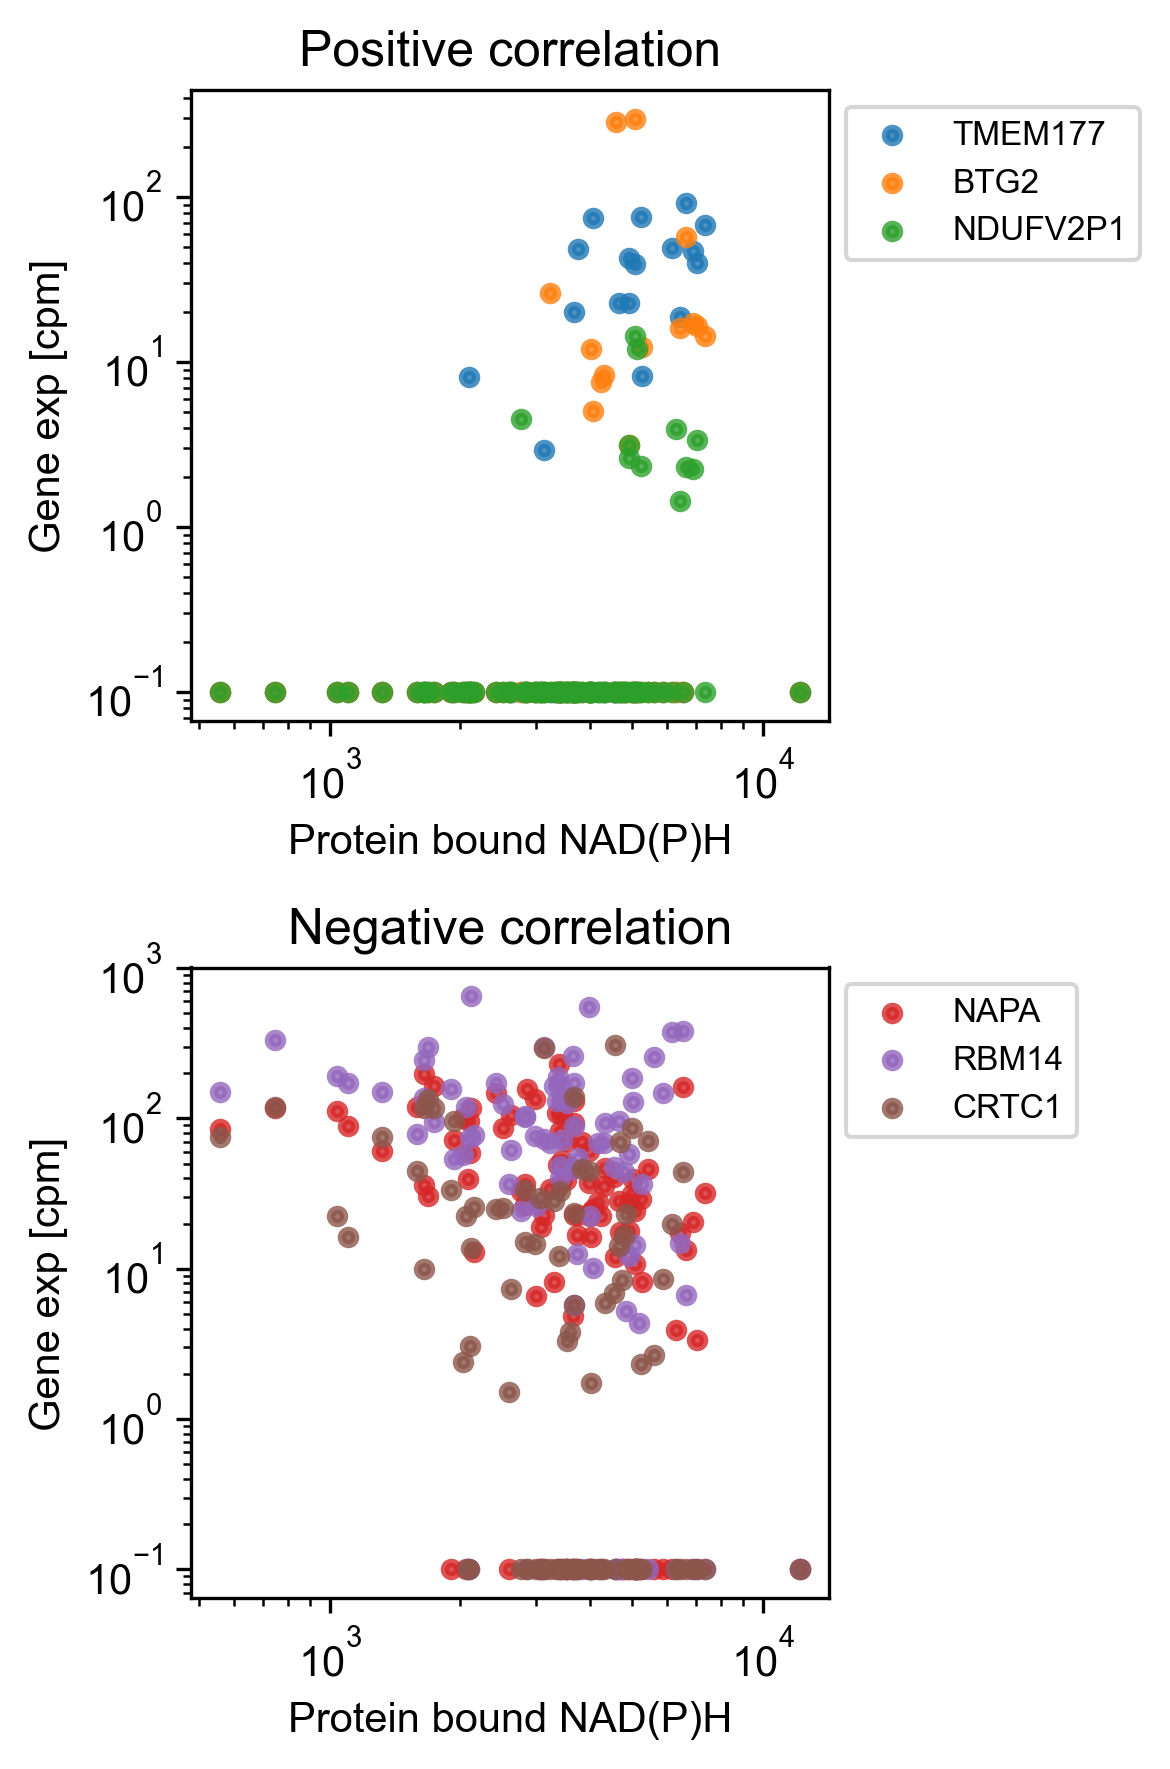

In [24]:
feas = ['Free NAD(P)H', 'Protein bound NAD(P)H']
xlabels = ['Free NAD(P)H', 'Protein bound NAD(P)H']

for fea, xlabel in zip(feas, xlabels):

    path = save_figures
    filetype = '.png' 
    genes = {
        'positive': corr.nlargest(3, fea).index.tolist(),
        'negative': corr.nsmallest(3, fea).index.tolist(),
    }
    plot_correlation(genes, adata_s, fea, xlabel, path, filetype='.png')
#     plot_correlation(genes, adata_s, fea, xlabel, path, filetype='.pdf')

In [99]:
corr.fillna(0)['Free NAD(P)H'].sort_values(ascending=False)[:100].index

Index(['BBX', 'PBX1', 'NLRC3', 'FAM21A', 'SS18L1', 'HIST2H4A', 'COBL', 'HYPK',
       'RP11-380N8.7', 'RCAN3', 'MRPL23-1', 'RP5-1159O4.2', 'PCP4', 'TMEM14D',
       'P2RX4', 'EIF2B5', 'DALRD3', 'PPP1R18', 'RP11-214O14.1', 'IQCG',
       'NDUFV2P1', 'ATXN7L3', 'TCEAL1', 'CWC27', 'ITGB6', 'MALRD1', 'PYROXD1',
       'AC009362.2', 'AC090602.2', 'TCEAL8', 'KANSL1-AS1', 'DYRK2', 'RPL13P2',
       'ECI2', 'CEP78', 'RP13-977J11.2', 'RP11-823E8.3', 'RNF130',
       'RP3-340B19.2', 'CTD-3025N20.3', 'KB-1683C8.1', 'RWDD2B', 'GOLGA7B',
       'OSBPL10', 'FRMD4A', 'WISP2', 'BDH2', 'P2RY6', 'RP11-133L19.3', 'METRN',
       'MRPS31P4', 'GABARAP', 'RPL13AP7', 'RP11-697N18.3', 'MMEL1', 'CAPN7',
       'FBXW4', 'RP11-299J3.8', 'SMPDL3B', 'SSPO', 'GSTM4', 'LRRC57', 'MMP16',
       'ZNF490', 'TSGA10', 'FAM134C', 'RP11-642A1.3', 'RP11-15E18.5', 'SYT12',
       'EEF2K', 'SNHG19', 'COL5A1', 'NUDT3', 'RCBTB1', 'AC136352.8',
       'RP3-423B22.5', 'PGGT1B', 'FBXL16', 'BAHCC1', 'RP11-147L13.13',
       'LAMTOR

In [95]:
corr.fillna(0)['Protein bound NAD(P)H'].sort_values(ascending=False)[-100:].index

Index(['HYOU1', 'BCAM', 'PEA15', 'HGH1', 'FAF2', 'HIPK2', 'CHSY1', 'USP12',
       'FCF1', 'RP11-75C10.9', 'FAM217B', 'LRRFIP1', 'ABCA2', 'ATP8B1',
       'TUFT1', 'GALC', 'RIPPLY3', 'AMIGO2', 'AC073072.7', 'SLC25A13', 'ALG3',
       'STT3A', 'PRDM2', 'TMEM259', 'SLC35A4', 'TCERG1', 'CASKIN2', 'THAP4',
       'PGD', 'DHFRP1', 'RN7SL767P', 'MAX', 'HNRNPAB', 'SAMD4B', 'TUBGCP4',
       'NBPF1', 'ALDOA', 'PVRL1', 'SHC1', 'HGS', 'GBA2', 'MCU', 'COPA',
       'CKAP5', 'HSPH1', 'TAGLN2', 'PTRH2', 'BCCIP', 'DHFR', 'SPEN', 'SMARCD1',
       'YWHAZP3', 'AKR1C1', 'EXOC8', 'XPO6', 'NPLOC4', 'YME1L1', 'SACM1L',
       'RP11-554E23.4', 'PRKDC', 'CCNK', 'DOT1L', 'RPN1', 'GTF3C4', 'HNRNPC',
       'RASAL1', 'ANAPC1', 'NPIPB3', 'SP1', 'RP9', 'Metazoa_SRP-128', 'ATMIN',
       'MLF2', 'RPS26P3', 'CSE1L', 'SNORD3A', 'MTND1P23', 'ATXN2L', 'WDR5',
       'TSC22D2', 'FARSB', 'BAZ2A', 'HMGA1', 'HSP90AA1', 'PITRM1', 'ST14',
       'ELL2', 'BRAT1', 'PPM1H', 'RPS26', 'NR1H3', 'CASC4', 'PACS1', 'WNK1',
       '